In [1]:
import os
classes = ["kangaroo","raccoon"]
annot_lists=[]
for classename in classes:
    my_source="data/%s/annotations"%(classename)
    for dirpath, dirname, files in os.walk(my_source):
        for file in files:
            annot_lists.append("./"+dirpath+"/"+file)
            
if not os.path.exists("K&C_train.txt"): # 範例中訓練模型時所使用的，已經做好轉換的 annotation 檔名，增加這個檢查避免每次重新跑這段轉換的程式碼
    import xml.etree.ElementTree as ET # 載入能夠 Parser xml 文件的 library
    from os import getcwd

    # 資料類別
    classes = ["kangaroo","raccoon"]

    # 把 annotation 轉換訓練時需要的資料形態
    def convert_annotation(classname, image_id, list_file):
        in_file = open('data/%s/annotations/%s.xml'%(classname, image_id))
        tree=ET.parse(in_file)
        root = tree.getroot()

        for obj in root.iter('object'):
          difficult = obj.find('difficult').text
          cls = obj.find('name').text
          if cls not in classes or int(difficult)==1:
              continue
          cls_id = classes.index(cls)
          xmlbox = obj.find('bndbox')
          b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
          list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

    annotation_path='K&C_train.txt'
    list_file = open(annotation_path, 'w')
    print("save annotation at %s" % annotation_path)
    for i in range(len(annot_lists)):
        list_file.write(annot_lists[i].replace("annotations","images").replace("xml","jpg") )
        image_id=annot_lists[i].split('/')[-1].split('.xml')[0]
        classname=annot_lists[i].split('/')[2]
        convert_annotation(classname,image_id, list_file)
        list_file.write('\n')
    list_file.close()

In [2]:
import os
if not os.path.exists("model_data/yolo_weights.h5"):
    # 下載 yolov3 的網路權重(.weights)，並且把權重轉換為 keras 能夠讀取的格式(.h5)
    print("Converting pretrained YOLOv3 weights for training")
    #把 YOLO weights 轉換為能夠提供給 keras 作為訓練新模型的初始權重,注意argument 要使用 -w 
    os.system("python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5") 
else:
    print("Pretrained weights exists")

Pretrained weights exists


In [3]:
import tensorflow as tf
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [4]:
from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data
from train import get_classes, get_anchors, create_model, create_tiny_model, data_generator, data_generator_wrapper

In [6]:
annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/001/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/K&C_classes.txt.txt' # 加入類別 kangaroo & raccoon
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
input_shape = (416,416) # multiple of 32, hw

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    model = create_tiny_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/tiny_yolo_weights.h5')
else:
    model = create_model(input_shape, anchors, num_classes,
        freeze_body=2, weights_path='model_data/yolo_weights.h5') # make sure you know what you freeze

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Train with frozen layers first, to get a stable loss.
# Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# 一開始先 freeze YOLO 除了 output layer 以外的 darknet53 backbone 來 train
if True:
    model.compile(optimizer=Adam(lr=1e-3), loss={
        # use custom yolo_loss Lambda layer.
        'yolo_loss': lambda y_true, y_pred: y_pred})

    batch_size = 16
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    # 模型利用 generator 產生的資料做訓練，強烈建議大家去閱讀及理解 data_generator_wrapper 在 train.py 中的實現
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
            steps_per_epoch=max(1, num_train//batch_size),
            validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
            validation_steps=max(1, num_val//batch_size),
            epochs=50,
            initial_epoch=0,
            callbacks=[logging, checkpoint])
    model.save_weights(log_dir + 'trained_weights_stage_1.h5')

Create YOLOv3 model with 9 anchors and 2 classes.


C:\Users\whyuc\Anaconda3\envs\DLlow\lib\site-packages\keras\engine\topology.py:3242: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 21) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
C:\Users\whyuc\Anaconda3\envs\DLlow\lib\site-packages\keras\engine\topology.py:3242: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\whyuc\Anaconda3\envs\DLlow\lib\site-packages\keras\engine\topology.py:3242: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 21) vs (255, 512, 1, 1)).
  weight_values[i].shape))
C:\Users\whyuc\Anaconda3\envs\DLlow\lib\site-packages\keras\engine\topology.py:3242: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((21,) vs (255,)).
  weight_values[i].shape))
C:\Users\whyuc\Anaconda3\envs\DLlow\lib\site-packages\keras\engine\topology.py:3242: UserW

Load weights model_data/yolo_weights.h5.
Freeze the first 249 layers of total 252 layers.
Train on 328 samples, val on 36 samples, with batch size 16.
Epoch 1/50
20/20 [==============================] - 23s 1s/step - loss: 3292.3438 - val_loss: 820.7231
Epoch 2/50
20/20 [==============================] - 19s 956ms/step - loss: 468.7842 - val_loss: 277.6591
Epoch 3/50
20/20 [==============================] - 34s 2s/step - loss: 216.9023 - val_loss: 170.0491
Epoch 4/50
20/20 [==============================] - 12s 622ms/step - loss: 157.4850 - val_loss: 130.8234
Epoch 5/50
20/20 [==============================] - 21s 1s/step - loss: 122.3486 - val_loss: 106.6112
Epoch 6/50
20/20 [==============================] - 20s 1s/step - loss: 103.1741 - val_loss: 88.2560
Epoch 7/50
20/20 [==============================] - 19s 974ms/step - loss: 90.5021 - val_loss: 83.3441
Epoch 8/50
20/20 [==============================] - 20s 977ms/step - loss: 77.6956 - val_loss: 70.9088
Epoch 9/50
20/20 [=======

In [10]:
input_shape = (416,416) # multiple of 32, hw
weights_path=log_dir + 'trained_weights_stage_1.h5'
model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

is_tiny_version = len(anchors)==6 # default setting
if is_tiny_version:
    weights_path=log_dir + 'trained_tiny_weights_stage_1.h5'
    model = create_tiny_model(input_shape, anchors, num_classes,weights_path=weights_path)
else:
    weights_path=log_dir + 'trained_weights_stage_1.h5'
    model = create_model(input_shape, anchors, num_classes, weights_path=weights_path)

logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# 分為 training 以及 validation
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

# Unfreeze and continue training, to fine-tune.
# Train longer if the result is not good.
if True:
    # 把所有 layer 都改為 trainable
    for i in range(len(model.layers)):
        model.layers[i].trainable = True
    model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
    print('Unfreeze all of the layers.')

    batch_size = 2 # note that more GPU memory is required after unfreezing the body
    print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
    model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=100,
        initial_epoch=50,
        callbacks=[logging, checkpoint, reduce_lr, early_stopping])
    model.save_weights(log_dir + 'trained_weights_final.h5')

Create YOLOv3 model with 9 anchors and 2 classes.
Load weights logs/001/trained_weights_stage_1.h5.
Freeze the first 249 layers of total 252 layers.
Create YOLOv3 model with 9 anchors and 2 classes.
Load weights logs/001/trained_weights_stage_1.h5.
Freeze the first 249 layers of total 252 layers.
Unfreeze all of the layers.
Train on 328 samples, val on 36 samples, with batch size 2.
Epoch 51/100
164/164 [==============================] - 71s 435ms/step - loss: 19.5965 - val_loss: 18.3774
Epoch 52/100
164/164 [==============================] - 62s 377ms/step - loss: 17.5490 - val_loss: 17.2497
Epoch 53/100
164/164 [==============================] - 92s 563ms/step - loss: 17.0548 - val_loss: 16.8405
Epoch 54/100
164/164 [==============================] - 62s 377ms/step - loss: 17.0885 - val_loss: 17.0700
Epoch 55/100
164/164 [==============================] - 62s 378ms/step - loss: 16.5129 - val_loss: 16.7146
Epoch 56/100
164/164 [==============================] - 62s 380ms/step - loss: 

In [11]:
from yolo import YOLO

annotation_path = 'K&C_train.txt' # 轉換好格式的標註檔案
log_dir = 'logs/001/' # 訓練好的模型儲存的路徑
classes_path = 'model_data/K&C_classes.txt.txt'
anchors_path = 'model_data/yolo_anchors.txt'

yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)



logs/001/trained_weights_final.h5 model, anchors, and classes loaded.


(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (653, 0) (1113, 578)
0.09510010000030888


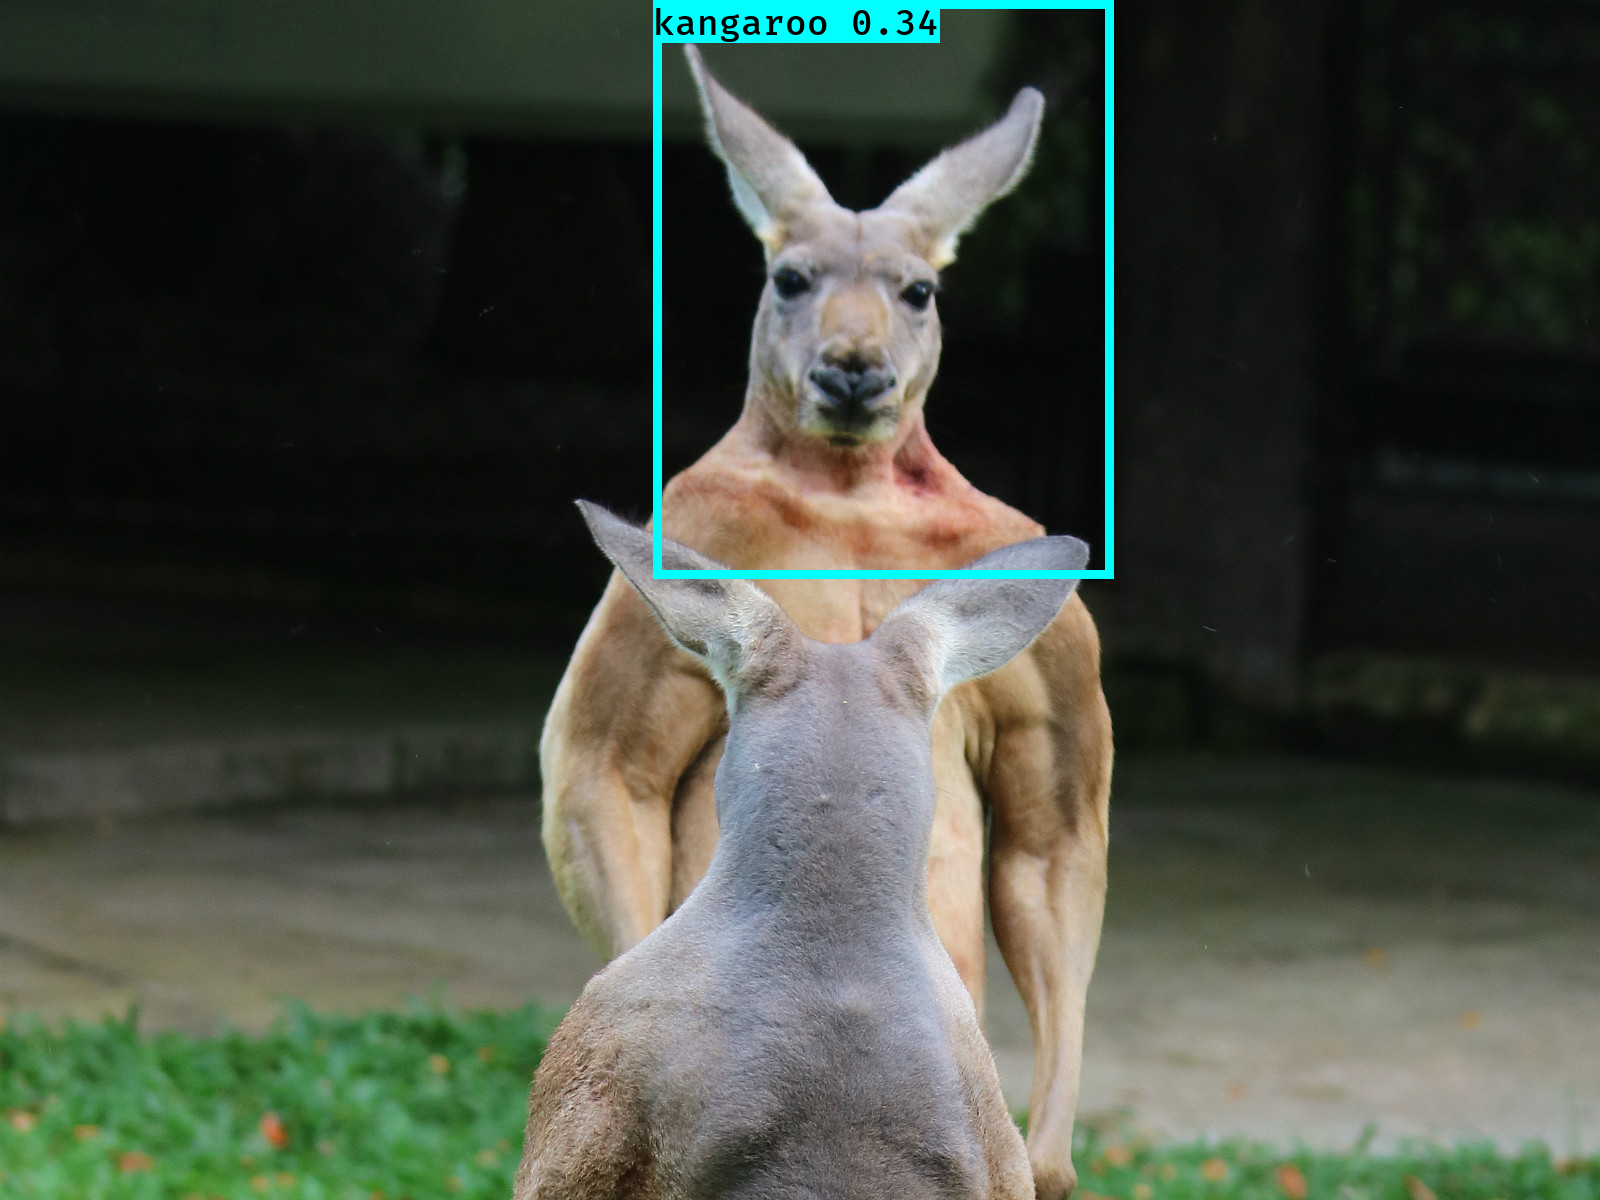

In [23]:
from PIL import Image
image = Image.open('PIC1.jpg')  # 選擇測試用照片
r_image = yolo_model.detect_image(image)
r_image

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (90, 64) (528, 359)
0.09073910000006435


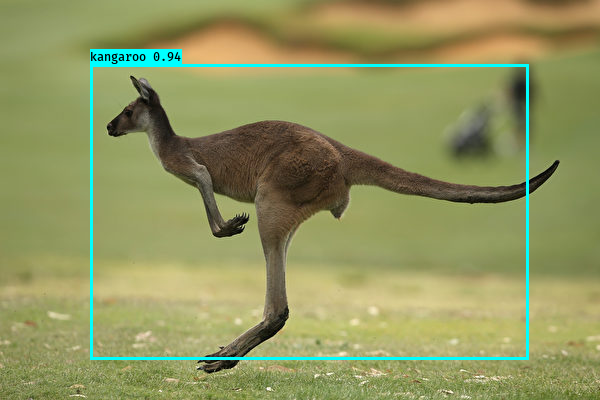

In [30]:
image = Image.open('PIC2.jpg')  # 選擇測試用照片
r_image = yolo_model.detect_image(image)
r_image

(416, 416, 3)
Found 1 boxes for img
kangaroo 1.00 (46, 84) (581, 567)
0.07716179999988526


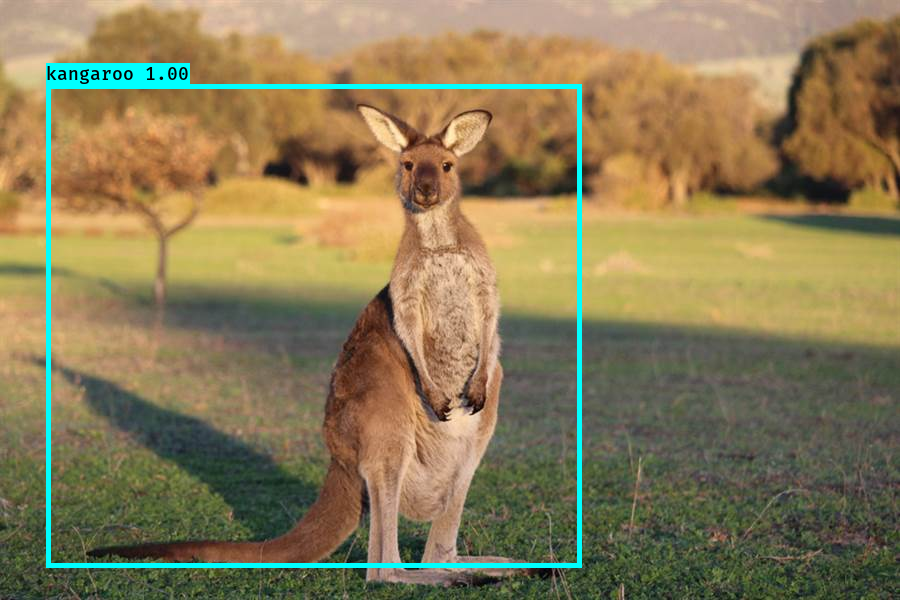

In [31]:
image = Image.open('PIC3.jpg')  # 選擇測試用照片
r_image = yolo_model.detect_image(image)
r_image

(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (36, 0) (381, 284)
0.07183679999980086


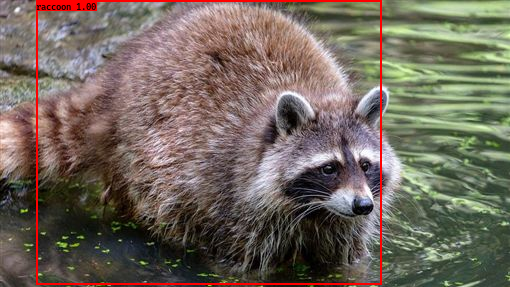

In [32]:
image = Image.open('PIC4.jpg')  # 選擇測試用照片
r_image = yolo_model.detect_image(image)
r_image

(416, 416, 3)
Found 2 boxes for img
raccoon 0.95 (7, 0) (140, 224)
raccoon 0.99 (104, 20) (223, 224)
0.08287639999980456


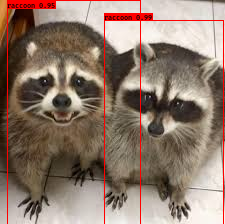

In [33]:
image = Image.open('PIC5.jpg')  # 選擇測試用照片
r_image = yolo_model.detect_image(image)
r_image

In [24]:
def video_detect(video_path, output_path):
    import cv2
    import numpy as np
    from PIL import Image
    import timeit

    starttime = timeit.default_timer()
    cap = cv2.VideoCapture(video_path)

    # 使用 XVID 編碼
    fourcc = cv2.VideoWriter_fourcc(*'XVID')

    # 建立 VideoWriter 物件，輸出影片至 output.avi , FPS 值為 30.0，解析度為 1280*720
    out = cv2.VideoWriter(output_path, fourcc, 30.0, (1280, 720))

    k = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            # 寫入影格
            image = Image.fromarray(frame)
            image = np.array(yolo_model.detect_image(image))
            out.write(image)
            k += 1
        else:
            break
        
    # 釋放所有資源
    cap.release()
    out.release()
    print('共耗時:',round((timeit.default_timer() - starttime), 2), '秒，FPS:', round(k/(timeit.default_timer() - starttime), 2))

In [28]:
video_input='Kangaroo.mp4'
video_output='Kangaroo-YOLO.mp4'
#yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
video_detect(video_path=video_input,output_path=video_output)

(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (331, 0) (772, 700)
0.09680440000011004
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (331, 0) (772, 700)
0.07142800000019633
(416, 416, 3)
Found 1 boxes for img
raccoon 0.80 (332, 3) (772, 697)
0.07033189999992828
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (355, 12) (745, 689)
0.06793930000003456
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (323, 2) (768, 700)
0.07085570000026564
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (290, 0) (801, 708)
0.06859269999995377
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (280, 0) (812, 696)
0.06790130000035788
(416, 416, 3)
Found 0 boxes for img
0.06801139999970474
(416, 416, 3)
Found 0 boxes for img
0.06514320000042062
(416, 416, 3)
Found 1 boxes for img
raccoon 0.51 (285, 0) (799, 720)
0.06740040000022418
(416, 416, 3)
Found 0 boxes for img
0.06877329999997528
(416, 416, 3)
Found 0 boxes for img
0.0665817999997671
(416, 416, 3)
Found 0 boxes for img
0.06496300000026167
(416, 41

Found 1 boxes for img
kangaroo 0.99 (435, 48) (1054, 675)
0.0720698000000084
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (458, 21) (1039, 695)
0.07026839999980439
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (454, 19) (1042, 700)
0.07070470000007845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (465, 14) (1037, 710)
0.07021489999988262
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (465, 13) (1038, 711)
0.0680395999997927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (463, 7) (1044, 714)
0.06994970000005196
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (464, 0) (1047, 710)
0.07026240000004691
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (483, 22) (1132, 699)
0.06768240000019432
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (484, 13) (1131, 709)
0.06766040000002249
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (484, 13) (1131, 709)
0.06936309999991863
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (455, 0) (1057, 720)
0.06779050000022835
(416, 416, 3)

Found 1 boxes for img
raccoon 0.94 (0, 0) (1078, 720)
0.06881320000002233
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (1054, 720)
0.06747289999975692
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1048, 720)
0.06740179999997054
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (0, 0) (1027, 720)
0.06917720000001282
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 0) (981, 720)
0.0678342999999586
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (0, 0) (955, 720)
0.06711519999998927
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (0, 0) (955, 720)
0.0682846999998219
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (955, 720)
0.06725060000007943
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (0, 0) (955, 720)
0.067526799999996
(416, 416, 3)
Found 1 boxes for img
raccoon 0.85 (0, 0) (910, 720)
0.06998990000010963
(416, 416, 3)
Found 1 boxes for img
raccoon 0.82 (0, 0) (900, 720)
0.06828600000017104
(416, 416, 3)
Found 1 boxes for img
raccoon 0.86 (0, 0) (

Found 1 boxes for img
kangaroo 0.47 (65, 112) (360, 440)
0.06986159999996744
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (59, 131) (374, 441)
0.06727039999987028
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (61, 131) (370, 439)
0.06856890000017302
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (49, 156) (394, 431)
0.06923989999995683
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (44, 153) (407, 433)
0.06832570000005944
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.73 (31, 152) (424, 433)
0.06753409999964788
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (39, 159) (420, 429)
0.06951660000004267
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.84 (40, 158) (421, 430)
0.06881119999980001
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.74 (34, 163) (423, 421)
0.06772389999969164
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (38, 164) (421, 420)
0.07069069999988642
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.63 (38, 161) (412, 418)
0.06928339999967648
(416, 416, 3)

Found 3 boxes for img
kangaroo 0.70 (542, 95) (660, 169)
kangaroo 0.75 (1029, 442) (1280, 526)
kangaroo 0.88 (696, 384) (908, 509)
0.0772938999998587
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.41 (580, 83) (663, 183)
kangaroo 0.65 (1037, 439) (1280, 529)
kangaroo 0.96 (691, 395) (949, 501)
0.07621149999977206
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.48 (559, 100) (693, 165)
kangaroo 0.49 (1096, 437) (1280, 545)
kangaroo 0.83 (712, 394) (947, 507)
0.0743678000003456
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (747, 377) (955, 508)
0.07001799999989089
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (778, 367) (981, 516)
0.07110599999987244
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (777, 368) (982, 517)
0.07200539999985267
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.94 (802, 364) (1000, 500)
0.07083009999996648
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.95 (832, 370) (1010, 491)
0.07247490000008838
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.36 (663, 10

Found 1 boxes for img
kangaroo 0.83 (601, 36) (1051, 720)
0.06994830000030561
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (600, 36) (1055, 720)
0.07036359999983688
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.82 (607, 31) (1048, 720)
0.07145399999990332
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (611, 34) (1048, 720)
0.07031810000034966
(416, 416, 3)
Found 2 boxes for img
raccoon 0.36 (614, 31) (1050, 720)
kangaroo 0.62 (614, 31) (1050, 720)
0.0719902999999249
(416, 416, 3)
Found 2 boxes for img
raccoon 0.33 (614, 35) (1050, 720)
kangaroo 0.65 (614, 35) (1050, 720)
0.07259380000004967
(416, 416, 3)
Found 2 boxes for img
raccoon 0.31 (622, 36) (1051, 720)
kangaroo 0.65 (622, 36) (1051, 720)
0.07689029999983177
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (601, 65) (1083, 715)
kangaroo 0.64 (674, 77) (1032, 720)
0.0735088999999789
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (604, 81) (1090, 702)
0.07034479999992982
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.8

(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (700, 372) (1046, 587)
0.07136980000041149
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (731, 333) (1075, 549)
0.06987090000029639
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (731, 333) (1075, 549)
0.07143300000007002
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.80 (717, 318) (1095, 538)
0.07028690000015558
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.78 (200, 331) (708, 628)
kangaroo 0.87 (734, 295) (1085, 507)
0.07809500000030312
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.85 (740, 293) (1086, 496)
kangaroo 0.87 (335, 317) (713, 619)
0.07403690000001006
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (746, 302) (1071, 491)
kangaroo 0.75 (159, 265) (766, 656)
0.07371359999979177
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.66 (746, 302) (1071, 491)
kangaroo 0.79 (161, 268) (766, 652)
0.07441259999995964
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.45 (317, 264) (736, 455)
kangaroo 0.66 (745, 303) (1065, 483)
0.0

Found 1 boxes for img
kangaroo 0.88 (601, 134) (1058, 593)
0.07243849999986196
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (598, 136) (1061, 593)
0.07203100000015183
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.87 (600, 137) (1061, 590)
0.07207289999996647
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (600, 137) (1060, 593)
0.07251229999974385
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.89 (600, 137) (1060, 593)
0.07157199999983277
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (602, 133) (1062, 596)
0.07115680000015345
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.88 (604, 131) (1060, 598)
0.07232119999980569
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (603, 132) (1061, 596)
0.07442910000008851
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (610, 128) (1058, 593)
0.07540070000004562
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.79 (610, 128) (1058, 593)
0.07741159999977754
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.83 (604, 128) (1055, 596)
0.078922900

Found 0 boxes for img
0.06935909999992873
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (0, 62) (1189, 667)
0.07183209999993778
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (0, 11) (1089, 696)
0.07186259999980393
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (0, 12) (1087, 697)
0.07266639999988911
(416, 416, 3)
Found 1 boxes for img
raccoon 0.47 (4, 16) (1071, 698)
0.07207289999996647
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (0, 3) (1096, 707)
0.07415270000001328
(416, 416, 3)
Found 0 boxes for img
0.06868420000000697
(416, 416, 3)
Found 1 boxes for img
raccoon 0.75 (0, 4) (1126, 713)
0.07077440000011848
(416, 416, 3)
Found 1 boxes for img
raccoon 0.76 (0, 5) (1126, 713)
0.07153729999981806
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (0, 0) (1128, 719)
0.07143670000004931
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (43, 9) (1217, 714)
0.07204180000007909
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (25, 0) (1238, 720)
0.07052539999995133
(416, 416, 3)
Fo

0.07610029999977996
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (0, 0) (1279, 687)
kangaroo 0.39 (0, 0) (1280, 651)
0.07757410000021991
(416, 416, 3)
Found 2 boxes for img
raccoon 0.61 (0, 0) (1280, 651)
kangaroo 0.60 (0, 48) (1277, 643)
0.07690210000009756
(416, 416, 3)
Found 2 boxes for img
raccoon 0.67 (0, 0) (1280, 643)
kangaroo 0.42 (0, 0) (1273, 628)
0.07577320000018517
(416, 416, 3)
Found 2 boxes for img
raccoon 0.65 (0, 0) (1280, 698)
kangaroo 0.43 (0, 0) (1273, 626)
0.0754879000000983
(416, 416, 3)
Found 2 boxes for img
raccoon 0.78 (0, 5) (1280, 702)
kangaroo 0.30 (0, 0) (1231, 614)
0.07655720000002475
(416, 416, 3)
Found 2 boxes for img
raccoon 0.77 (0, 20) (1280, 682)
kangaroo 0.41 (0, 0) (1213, 601)
0.07474939999974595
(416, 416, 3)
Found 2 boxes for img
raccoon 0.63 (0, 28) (1280, 672)
kangaroo 0.44 (0, 74) (1280, 630)
0.07466419999991558
(416, 416, 3)
Found 2 boxes for img
raccoon 0.45 (0, 35) (1280, 665)
kangaroo 0.58 (0, 55) (1280, 654)
0.07556679999970584
(416, 4

(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (0, 0) (1280, 720)
0.07116110000015397
(416, 416, 3)
Found 1 boxes for img
raccoon 0.70 (0, 0) (1280, 720)
0.0681352000001425
(416, 416, 3)
Found 1 boxes for img
raccoon 0.81 (0, 5) (1280, 698)
0.07165209999993749
(416, 416, 3)
Found 1 boxes for img
raccoon 0.42 (0, 0) (1280, 629)
0.07130319999987478
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (0, 0) (1280, 624)
0.06911989999980506
(416, 416, 3)
Found 0 boxes for img
0.06593299999985902
(416, 416, 3)
Found 0 boxes for img
0.0659021000001303
(416, 416, 3)
Found 0 boxes for img
0.06835499999988315
(416, 416, 3)
Found 0 boxes for img
0.06853619999992588
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (0, 0) (1280, 621)
0.0711527999997088
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (0, 0) (1280, 598)
0.07109009999976479
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (0, 0) (1280, 599)
0.067950799999835
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (0, 0) (1280, 606)
0.06

(416, 416, 3)
Found 2 boxes for img
kangaroo 0.42 (951, 363) (1005, 517)
kangaroo 0.65 (834, 434) (919, 602)
0.07267109999975219
(416, 416, 3)
Found 3 boxes for img
kangaroo 0.45 (948, 352) (1003, 537)
kangaroo 0.48 (826, 407) (926, 627)
kangaroo 0.67 (648, 399) (703, 538)
0.07189840000000913
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (641, 391) (720, 537)
kangaroo 0.56 (940, 318) (1007, 528)
0.07115299999986746
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.50 (641, 392) (720, 537)
kangaroo 0.56 (940, 318) (1007, 528)
0.07071429999996326
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.39 (938, 309) (1003, 532)
0.06897679999974571
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.37 (938, 314) (996, 525)
0.07258900000033464
(416, 416, 3)
Found 2 boxes for img
kangaroo 0.39 (1165, 294) (1228, 453)
kangaroo 0.42 (787, 486) (874, 649)
0.07152310000037687
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.47 (772, 460) (866, 668)
0.06874920000018392
(416, 416, 3)
Found 1 boxes for img
kanga

Found 0 boxes for img
0.06666639999957624
(416, 416, 3)
Found 0 boxes for img
0.06932700000015757
(416, 416, 3)
Found 0 boxes for img
0.06985190000023067
(416, 416, 3)
Found 0 boxes for img
0.06825320000007196
(416, 416, 3)
Found 0 boxes for img
0.06567400000039925
(416, 416, 3)
Found 0 boxes for img
0.06978039999967223
(416, 416, 3)
Found 0 boxes for img
0.06831469999997353
(416, 416, 3)
Found 0 boxes for img
0.06656419999990248
(416, 416, 3)
Found 0 boxes for img
0.06595319999996718
(416, 416, 3)
Found 0 boxes for img
0.06727170000021943
(416, 416, 3)
Found 0 boxes for img
0.06932760000017879
(416, 416, 3)
Found 0 boxes for img
0.06866170000012062
(416, 416, 3)
Found 0 boxes for img
0.0662171999997554
(416, 416, 3)
Found 0 boxes for img
0.06728479999992487
(416, 416, 3)
Found 0 boxes for img
0.06821209999998246
(416, 416, 3)
Found 0 boxes for img
0.0691765999999916
(416, 416, 3)
Found 0 boxes for img
0.06669409999994969
(416, 416, 3)
Found 0 boxes for img
0.0706676999998308
(416, 416

Found 0 boxes for img
0.06759950000014214
(416, 416, 3)
Found 0 boxes for img
0.06810249999989537
(416, 416, 3)
Found 0 boxes for img
0.06640939999988404
(416, 416, 3)
Found 0 boxes for img
0.06562030000031882
(416, 416, 3)
Found 0 boxes for img
0.06583309999996345
(416, 416, 3)
Found 0 boxes for img
0.06762639999988096
(416, 416, 3)
Found 0 boxes for img
0.06545869999990828
(416, 416, 3)
Found 0 boxes for img
0.06964569999991
(416, 416, 3)
Found 0 boxes for img
0.06535230000008596
(416, 416, 3)
Found 0 boxes for img
0.06607779999967534
(416, 416, 3)
Found 0 boxes for img
0.06737089999978707
(416, 416, 3)
Found 0 boxes for img
0.06586130000005141
(416, 416, 3)
Found 0 boxes for img
0.0654751000001852
(416, 416, 3)
Found 0 boxes for img
0.06838020000031975
(416, 416, 3)
Found 0 boxes for img
0.06543759999976828
(416, 416, 3)
Found 0 boxes for img
0.06650690000014947
(416, 416, 3)
Found 0 boxes for img
0.06566659999998592
(416, 416, 3)
Found 0 boxes for img
0.06527639999967505
(416, 416,

Found 1 boxes for img
kangaroo 0.93 (593, 30) (1074, 514)
0.06977149999966059
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (586, 24) (1070, 519)
0.07044479999967734
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (583, 27) (1062, 516)
0.06946379999999408
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.85 (577, 33) (1061, 519)
0.0674258999997619
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.81 (586, 24) (1047, 520)
0.06780179999987013
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.86 (580, 27) (1053, 520)
0.06905039999992368
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (580, 25) (1050, 529)
0.06844939999973576
(416, 416, 3)
Found 2 boxes for img
raccoon 0.53 (544, 0) (998, 693)
kangaroo 0.75 (566, 27) (1056, 542)
0.07355869999992137
(416, 416, 3)
Found 2 boxes for img
raccoon 0.42 (547, 0) (997, 694)
kangaroo 0.81 (570, 28) (1050, 541)
0.06968479999977717
(416, 416, 3)
Found 2 boxes for img
raccoon 0.35 (540, 0) (1002, 680)
kangaroo 0.82 (567, 36) (1052, 530)
0.0711565000001

(416, 416, 3)
Found 0 boxes for img
0.0681973000000653
(416, 416, 3)
Found 0 boxes for img
0.06529649999993126
(416, 416, 3)
Found 0 boxes for img
0.06599380000034216
(416, 416, 3)
Found 0 boxes for img
0.06539440000005925
(416, 416, 3)
Found 0 boxes for img
0.06518589999996038
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.60 (364, 302) (560, 581)
0.06961409999985335
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (364, 302) (560, 582)
0.0700925000001007
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.43 (364, 308) (560, 573)
0.06867030000012164
(416, 416, 3)
Found 0 boxes for img
0.0651173999999628
(416, 416, 3)
Found 0 boxes for img
0.06531549999999697
(416, 416, 3)
Found 0 boxes for img
0.06702529999984108
(416, 416, 3)
Found 0 boxes for img
0.06579569999985324
(416, 416, 3)
Found 0 boxes for img
0.0688241000002563
(416, 416, 3)
Found 0 boxes for img
0.06568820000029518
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.34 (309, 308) (527, 575)
0.06828459999996994
(416, 416, 3)
Found 

Found 0 boxes for img
0.06937510000034308
(416, 416, 3)
Found 0 boxes for img
0.06646590000036667
(416, 416, 3)
Found 0 boxes for img
0.06583610000006956
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.44 (577, 303) (954, 620)
0.06892080000034184
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.46 (578, 302) (954, 618)
0.06751649999978326
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.58 (563, 296) (964, 622)
0.0683947000002263
(416, 416, 3)
Found 1 boxes for img
raccoon 0.94 (308, 8) (828, 664)
0.06821360000003551
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (303, 0) (826, 675)
0.06822809999994206
(416, 416, 3)
Found 1 boxes for img
raccoon 0.53 (255, 0) (851, 699)
0.07170059999998557
(416, 416, 3)
Found 1 boxes for img
raccoon 0.57 (254, 0) (853, 699)
0.06890829999974812
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (235, 0) (857, 695)
0.06892549999975017
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (235, 0) (858, 680)
0.06852549999985058
(416, 416, 3)
Found 1 boxes for img
r

In [20]:
?yolo_model

In [29]:
video_input='Raccoon.mp4'
video_output='Raccoon-YOLO.mp4'
#yolo_model = YOLO(model_path=log_dir + 'trained_weights_final.h5', classes_path=classes_path)
video_detect(video_path=video_input,output_path=video_output)

(416, 416, 3)
Found 0 boxes for img
0.08248309999999037
(416, 416, 3)
Found 0 boxes for img
0.07016040000007706
(416, 416, 3)
Found 0 boxes for img
0.07308210000019244
(416, 416, 3)
Found 0 boxes for img
0.06791999999995824
(416, 416, 3)
Found 0 boxes for img
0.06774360000008528
(416, 416, 3)
Found 0 boxes for img
0.06685090000019045
(416, 416, 3)
Found 0 boxes for img
0.06637759999966875
(416, 416, 3)
Found 0 boxes for img
0.06779920000008133
(416, 416, 3)
Found 0 boxes for img
0.06580620000022464
(416, 416, 3)
Found 0 boxes for img
0.06522069999982705
(416, 416, 3)
Found 0 boxes for img
0.0672485999998571
(416, 416, 3)
Found 0 boxes for img
0.06568179999976564
(416, 416, 3)
Found 0 boxes for img
0.06707550000010087
(416, 416, 3)
Found 0 boxes for img
0.06645929999967848
(416, 416, 3)
Found 0 boxes for img
0.06551540000009481
(416, 416, 3)
Found 0 boxes for img
0.06633060000012847
(416, 416, 3)
Found 0 boxes for img
0.06611430000020846
(416, 416, 3)
Found 0 boxes for img
0.06809789999

Found 0 boxes for img
0.06568620000007286
(416, 416, 3)
Found 0 boxes for img
0.06552830000009635
(416, 416, 3)
Found 0 boxes for img
0.06506709999985105
(416, 416, 3)
Found 0 boxes for img
0.06570119999969393
(416, 416, 3)
Found 0 boxes for img
0.06824999999980719
(416, 416, 3)
Found 0 boxes for img
0.06569509999962975
(416, 416, 3)
Found 0 boxes for img
0.06545879999976023
(416, 416, 3)
Found 0 boxes for img
0.06510960000014165
(416, 416, 3)
Found 0 boxes for img
0.06556450000016412
(416, 416, 3)
Found 0 boxes for img
0.06548109999994267
(416, 416, 3)
Found 0 boxes for img
0.0683592000000317
(416, 416, 3)
Found 0 boxes for img
0.06549999999970169
(416, 416, 3)
Found 0 boxes for img
0.0655759000001126
(416, 416, 3)
Found 0 boxes for img
0.0654460000000654
(416, 416, 3)
Found 0 boxes for img
0.06540339999992284
(416, 416, 3)
Found 0 boxes for img
0.06560320000016873
(416, 416, 3)
Found 0 boxes for img
0.06585889999996652
(416, 416, 3)
Found 0 boxes for img
0.06492439999965427
(416, 416

Found 0 boxes for img
0.0656314999996539
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (519, 5) (1223, 564)
0.06733719999965615
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (532, 12) (1213, 570)
0.07099200000038763
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (509, 6) (1280, 576)
0.06797249999999622
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (547, 50) (1271, 607)
0.06815319999986968
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (541, 57) (1278, 599)
0.06823430000031294
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (536, 9) (1278, 578)
0.06702619999987292
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (522, 3) (1280, 579)
0.06775649999963207
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (523, 0) (1280, 581)
0.07060580000006667
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (521, 2) (1280, 578)
0.0676714000001084
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (519, 0) (1280, 576)
0.06851549999964845
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (513, 0)

(416, 416, 3)
Found 0 boxes for img
0.06811900000002424
(416, 416, 3)
Found 0 boxes for img
0.06530320000001666
(416, 416, 3)
Found 0 boxes for img
0.06526759999997012
(416, 416, 3)
Found 0 boxes for img
0.06553770000027725
(416, 416, 3)
Found 0 boxes for img
0.06463750000011714
(416, 416, 3)
Found 0 boxes for img
0.06550240000024132
(416, 416, 3)
Found 0 boxes for img
0.06558989999984988
(416, 416, 3)
Found 0 boxes for img
0.06519630000002508
(416, 416, 3)
Found 0 boxes for img
0.06522419999964768
(416, 416, 3)
Found 0 boxes for img
0.06541409999999814
(416, 416, 3)
Found 0 boxes for img
0.06526389999999083
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (644, 65) (1274, 633)
0.0681829000000107
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (645, 66) (1274, 632)
0.06792989999985366
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (646, 67) (1273, 631)
0.06760429999985718
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (645, 66) (1274, 631)
0.06826090000004115
(416, 416, 3)
Found 1

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (21, 0) (1261, 720)
0.07037339999988035
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (29, 0) (1253, 720)
0.06747189999987313
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (20, 0) (1266, 720)
0.06730130000005374
(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (35, 0) (1258, 720)
0.06748379999999088
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (25, 0) (1269, 720)
0.06747919999997976
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (14, 0) (1277, 720)
0.06819020000011733
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (10, 0) (1280, 720)
0.06782320000002073
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (10, 0) (1280, 720)
0.06821829999989859
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (13, 0) (1280, 720)
0.06703429999970467
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (6, 0) (1280, 720)
0.06822779999993145
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (3, 0) (1280, 720)
0.06895769999982804
(416, 416, 3)
Found 1 b

(416, 416, 3)
Found 0 boxes for img
0.06833169999981692
(416, 416, 3)
Found 0 boxes for img
0.06517809999968449
(416, 416, 3)
Found 0 boxes for img
0.06537830000024769
(416, 416, 3)
Found 0 boxes for img
0.0654143000001568
(416, 416, 3)
Found 0 boxes for img
0.06530199999997421
(416, 416, 3)
Found 0 boxes for img
0.06582330000037473
(416, 416, 3)
Found 0 boxes for img
0.06850800000029267
(416, 416, 3)
Found 0 boxes for img
0.06561330000022281
(416, 416, 3)
Found 0 boxes for img
0.06545890000006693
(416, 416, 3)
Found 0 boxes for img
0.06622859999970387
(416, 416, 3)
Found 0 boxes for img
0.06652830000030008
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (337, 338) (705, 635)
0.06780930000013541
(416, 416, 3)
Found 0 boxes for img
0.06544720000010784
(416, 416, 3)
Found 1 boxes for img
raccoon 0.55 (335, 343) (711, 635)
0.07059630000003381
(416, 416, 3)
Found 1 boxes for img
raccoon 0.59 (333, 345) (713, 635)
0.06777349999993021
(416, 416, 3)
Found 1 boxes for img
raccoon 0.58 (330, 3

Found 1 boxes for img
raccoon 0.92 (32, 0) (1008, 720)
0.06796389999999519
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (37, 0) (1013, 720)
0.06837309999991703
(416, 416, 3)
Found 1 boxes for img
raccoon 0.88 (37, 0) (1013, 720)
0.0683963000001313
(416, 416, 3)
Found 1 boxes for img
raccoon 0.43 (0, 6) (1079, 720)
0.06927440000026763
(416, 416, 3)
Found 1 boxes for img
raccoon 0.41 (0, 6) (1080, 720)
0.0676461000002746
(416, 416, 3)
Found 0 boxes for img
0.06628130000035526
(416, 416, 3)
Found 0 boxes for img
0.06594880000011472
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (0, 5) (882, 720)
0.06755199999997785
(416, 416, 3)
Found 1 boxes for img
raccoon 0.36 (0, 5) (878, 720)
0.06729940000013812
(416, 416, 3)
Found 1 boxes for img
raccoon 0.64 (13, 0) (861, 720)
0.06839149999996152
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (12, 0) (861, 720)
0.07094219999999041
(416, 416, 3)
Found 1 boxes for img
raccoon 0.35 (0, 0) (881, 720)
0.0679696000001968
(416, 416, 3)
Found 1 box

Found 1 boxes for img
raccoon 0.99 (316, 37) (818, 568)
0.06828799999993862
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (327, 42) (813, 562)
0.06696069999998144
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (329, 35) (806, 567)
0.06766030000017054
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (312, 52) (913, 548)
0.07074839999995675
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (315, 45) (921, 553)
0.0675402000001668
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (316, 26) (916, 622)
0.06782949999978882
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (299, 9) (942, 648)
0.06795020000026852
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (290, 3) (953, 659)
0.06855059999998048
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (297, 46) (834, 631)
0.06938609999997425
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (296, 38) (838, 646)
0.06866260000015245
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (304, 34) (816, 661)
0.06976680000025226
(416, 416, 3)
Found 1 boxes

(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (419, 17) (1092, 644)
0.07038060000013502
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (417, 13) (1091, 644)
0.06769399999984671
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (423, 13) (1086, 644)
0.06807060000028287
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (422, 14) (1089, 643)
0.06733619999977236
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (413, 29) (1087, 626)
0.06773729999986244
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (415, 29) (1089, 628)
0.06864550000000236
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (394, 36) (1096, 623)
0.07010270000000673
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (360, 11) (1126, 574)
0.06824670000014521
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (356, 14) (1123, 573)
0.0673690000003262
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (360, 10) (1125, 577)
0.06791930000008506
(416, 416, 3)
Found 1 boxes for img
raccoon 0.99 (355, 9) (1125, 576)
0.06815069999993284
(

Found 1 boxes for img
raccoon 0.91 (620, 52) (1079, 635)
0.06821760000002541
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (611, 53) (1085, 635)
0.06782339999972464
(416, 416, 3)
Found 1 boxes for img
raccoon 0.91 (611, 44) (1084, 632)
0.06765469999982088
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (604, 45) (1087, 629)
0.06794429999990825
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (602, 39) (1088, 629)
0.06893410000020594
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (600, 45) (1088, 627)
0.06762879999996585
(416, 416, 3)
Found 1 boxes for img
raccoon 0.90 (586, 51) (1088, 618)
0.06756880000011734
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (594, 57) (1081, 624)
0.0675559000001158
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (589, 70) (1082, 620)
0.06838860000016211
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (582, 75) (1074, 616)
0.06810700000005454
(416, 416, 3)
Found 1 boxes for img
raccoon 0.93 (573, 72) (1077, 620)
0.07024730000011914
(416, 416, 3)


Found 1 boxes for img
raccoon 0.82 (301, 128) (736, 643)
0.06854300000031799
(416, 416, 3)
Found 1 boxes for img
raccoon 0.69 (310, 122) (737, 639)
0.06734550000010131
(416, 416, 3)
Found 1 boxes for img
raccoon 0.61 (326, 137) (743, 635)
0.06804650000003676
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (324, 159) (750, 693)
0.07111829999985275
(416, 416, 3)
Found 0 boxes for img
0.06547210000007908
(416, 416, 3)
Found 0 boxes for img
0.06515779999972438
(416, 416, 3)
Found 1 boxes for img
raccoon 0.62 (328, 190) (759, 680)
0.06860270000015589
(416, 416, 3)
Found 1 boxes for img
raccoon 0.45 (322, 175) (780, 688)
0.06806549999964773
(416, 416, 3)
Found 1 boxes for img
raccoon 0.34 (310, 191) (800, 675)
0.06805060000033336
(416, 416, 3)
Found 0 boxes for img
0.06599559999995108
(416, 416, 3)
Found 0 boxes for img
0.06594289999975445
(416, 416, 3)
Found 0 boxes for img
0.0657071000000542
(416, 416, 3)
Found 1 boxes for img
raccoon 0.46 (390, 178) (855, 677)
0.06750370000008843
(416, 4

Found 1 boxes for img
raccoon 1.00 (360, 87) (904, 658)
0.0681203999997706
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (361, 87) (902, 649)
0.06849499999998443
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (358, 87) (903, 646)
0.06968150000011519
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (356, 85) (900, 645)
0.06906369999978779
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (352, 87) (902, 639)
0.06756690000020171
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (351, 87) (900, 637)
0.0684651000001395
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (350, 88) (890, 635)
0.06830459999991945
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (349, 88) (892, 637)
0.06722369999988587
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (347, 92) (892, 639)
0.06760200000007899
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (349, 91) (896, 641)
0.07091110000010303
(416, 416, 3)
Found 1 boxes for img
raccoon 1.00 (340, 88) (903, 642)
0.06901620000007824
(416, 416, 3)
Found 1 boxe

(416, 416, 3)
Found 1 boxes for img
raccoon 0.96 (339, 8) (929, 720)
0.0716178000002401
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (347, 9) (922, 720)
0.06720249999989392
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (344, 12) (923, 720)
0.068368300000202
(416, 416, 3)
Found 1 boxes for img
raccoon 0.97 (328, 5) (933, 720)
0.06749929999978121
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (307, 1) (952, 720)
0.06725550000010116
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (300, 0) (954, 720)
0.06859960000019782
(416, 416, 3)
Found 1 boxes for img
raccoon 0.89 (292, 7) (957, 720)
0.07002130000000761
(416, 416, 3)
Found 1 boxes for img
raccoon 0.65 (272, 6) (974, 720)
0.0689618999999766
(416, 416, 3)
Found 1 boxes for img
raccoon 0.92 (283, 6) (956, 720)
0.06815830000005008
(416, 416, 3)
Found 1 boxes for img
raccoon 0.95 (283, 3) (950, 720)
0.06736540000019886
(416, 416, 3)
Found 1 boxes for img
raccoon 0.98 (284, 20) (945, 720)
0.0681601999999657
(416, 416, 3)
Found 1 bo

Found 1 boxes for img
raccoon 0.99 (63, 0) (1253, 641)
0.0686200000000099
(416, 416, 3)
Found 0 boxes for img
0.06532460000016727
(416, 416, 3)
Found 0 boxes for img
0.06538809999983641
(416, 416, 3)
Found 0 boxes for img
0.06854649999968387
(416, 416, 3)
Found 0 boxes for img
0.0658861000001707
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.31 (253, 405) (585, 644)
0.06949900000017806
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.59 (263, 402) (586, 645)
0.06828900000027716
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.54 (262, 401) (587, 647)
0.06778399999984686
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.40 (262, 403) (590, 644)
0.06858899999997448
(416, 416, 3)
Found 0 boxes for img
0.065224599999965
(416, 416, 3)
Found 0 boxes for img
0.06571179999991728
(416, 416, 3)
Found 0 boxes for img
0.06662210000013147
(416, 416, 3)
Found 0 boxes for img
0.06480680000004213
(416, 416, 3)
Found 0 boxes for img
0.065588000000389
(416, 416, 3)
Found 0 boxes for img
0.0659920999996757
(416

Found 0 boxes for img
0.06625480000002426
(416, 416, 3)
Found 0 boxes for img
0.06550229999993462
(416, 416, 3)
Found 0 boxes for img
0.06860469999992347
(416, 416, 3)
Found 0 boxes for img
0.06559489999972357
(416, 416, 3)
Found 0 boxes for img
0.06585309999991296
(416, 416, 3)
Found 0 boxes for img
0.06585510000013528
(416, 416, 3)
Found 0 boxes for img
0.06594640000002983
(416, 416, 3)
Found 0 boxes for img
0.06578820000004271
(416, 416, 3)
Found 0 boxes for img
0.06531330000007074
(416, 416, 3)
Found 0 boxes for img
0.06559900000002017
(416, 416, 3)
Found 0 boxes for img
0.06467389999988882
(416, 416, 3)
Found 0 boxes for img
0.06546780000007857
(416, 416, 3)
Found 0 boxes for img
0.06549610000001849
(416, 416, 3)
Found 0 boxes for img
0.06654980000030264
(416, 416, 3)
Found 0 boxes for img
0.06585470000027271
(416, 416, 3)
Found 0 boxes for img
0.0653585000000021
(416, 416, 3)
Found 0 boxes for img
0.06543899999996938
(416, 416, 3)
Found 0 boxes for img
0.06618990000015401
(416, 4

(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (770, 201) (983, 648)
kangaroo 0.69 (515, 251) (689, 593)
0.06961469999987457
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.75 (515, 247) (687, 604)
0.06778990000020713
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.77 (513, 254) (689, 594)
0.06813929999998436
(416, 416, 3)
Found 2 boxes for img
raccoon 0.38 (775, 202) (1017, 658)
kangaroo 0.75 (516, 265) (686, 585)
0.07249769999998534
(416, 416, 3)
Found 1 boxes for img
kangaroo 0.76 (519, 266) (683, 584)
0.0688257000001613
(416, 416, 3)
Found 2 boxes for img
raccoon 0.37 (769, 196) (1023, 663)
kangaroo 0.78 (517, 262) (685, 587)
0.06968659999984084
(416, 416, 3)
Found 2 boxes for img
raccoon 0.52 (773, 191) (1020, 670)
kangaroo 0.82 (518, 255) (686, 592)
0.07028989999980695
(416, 416, 3)
Found 2 boxes for img
raccoon 0.57 (775, 191) (1018, 670)
kangaroo 0.76 (515, 243) (689, 605)
0.07014209999988452
(416, 416, 3)
Found 2 boxes for img
raccoon 0.51 (776, 187) (1018, 676)
kangaroo 0.58 

Found 3 boxes for img
raccoon 0.35 (781, 174) (1019, 687)
kangaroo 0.57 (122, 322) (543, 644)
kangaroo 0.71 (519, 254) (681, 525)
0.07152129999985846
(416, 416, 3)
Found 3 boxes for img
raccoon 0.39 (780, 177) (1019, 686)
kangaroo 0.52 (122, 318) (541, 648)
kangaroo 0.73 (519, 253) (679, 528)
0.07214320000002772
(416, 416, 3)
Found 3 boxes for img
raccoon 0.41 (780, 182) (1019, 682)
kangaroo 0.52 (119, 316) (543, 651)
kangaroo 0.73 (521, 251) (678, 533)
0.07263430000011795
(416, 416, 3)
Found 3 boxes for img
raccoon 0.51 (783, 186) (1017, 679)
kangaroo 0.55 (120, 316) (539, 651)
kangaroo 0.70 (519, 253) (681, 533)
0.07226440000022194
(416, 416, 3)
Found 3 boxes for img
raccoon 0.47 (779, 183) (1019, 682)
kangaroo 0.51 (122, 315) (539, 650)
kangaroo 0.74 (518, 248) (680, 536)
0.0720925000000534
(416, 416, 3)
Found 3 boxes for img
raccoon 0.43 (776, 184) (1022, 679)
kangaroo 0.48 (124, 313) (536, 651)
kangaroo 0.64 (519, 254) (680, 531)
0.07498990000021877
(416, 416, 3)
Found 3 boxes for